In [1]:
import numpy as np
import scipy.signal as signal
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
import math
import tensorflow.keras.layers as tfl
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from numpy.linalg import cond
import os
import keras as k
import tensorflow.keras.backend as K
from keras.layers import *
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.optimizers import Adam, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
def mfcc_to_vocal_tract_envelope_time_domain(signal, fmin=0, fmax=300, n_fft=8192, sr=16000, n_mfcc=104, epsilon=1e-10):
    signal_length = len(signal)
    if fmin>fmax:
        fmax=sr//2
        n_mfcc=128

    # Compute MFCCs over the entire signal
    mfcc = librosa.feature.mfcc(
            y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=signal_length+1,
            fmin=fmin, fmax=fmax
        )

    # Select the first MFCC vector
    mfcc_first_vector = list(mfcc[:, 0])  # 1D array of length n_mfcc

    # Compute the inverse DCT to get back to the cepstral domain
    mfcc_dct = idct(mfcc_first_vector, type=2, norm='ortho')

    # Generate Mel frequency axis for plotting MFCC coefficients and power spectrum
    mel_frequencies = librosa.mel_frequencies(n_mels=n_mfcc, fmin=fmin, fmax=fmax)

    return mfcc_dct/np.max(np.abs(mfcc_dct)), mel_frequencies

In [13]:
def model_data(data_folder,fmin=0,fmax=300,frame_length_msec=30,num_frames=1000,sr=16000,verbose=True):
    X=[]
    Y=[]

    speakers_completed=0
    all_speakers=os.listdir(data_folder)
    print('Strating Process :')
    for speaker in all_speakers:
        flac_files = []

        for root, dirs, files in os.walk(os.path.join(data_folder,speaker)):
            for file in files:
                if file.endswith('.flac'):
                    full_path = os.path.join(root, file)
                    flac_files.append(full_path)
        y=[]
        req_len=frame_length_msec*(sr//1000)*num_frames
        for file in flac_files:
            y_curr, sr = librosa.load(file, sr=sr)
                
            non_silent_intervals = librosa.effects.split(y_curr, top_db=10)  # 20 dB threshold can be adjusted
            y_non_silent = []
            begin=0
            for start, end in non_silent_intervals:
                if start-begin<(50*sr//1000):
                    y_non_silent.extend(y_curr[begin:start])
                        
                y_non_silent.extend(y_curr[start:end])
                begin=start
        
            y.extend(y_non_silent)
            if len(y)>req_len:
                break
                
                
        del flac_files
                
        frame_length_samples=frame_length_msec*sr//1000
        frames = librosa.util.frame(y, frame_length=frame_length_samples, hop_length=frame_length_samples).T
        frames=frames[:num_frames]
        del y

        for frame in frames:
            vt,_=mfcc_to_vocal_tract_envelope_time_domain(frame,fmin,fmax)
            X.append(vt)
            Y.append(speaker)

            del vt

        del frames
                        
        speakers_completed += 1
        if speakers_completed != 0 and speakers_completed % 10 == 0 and verbose:
            print(f"{speakers_completed} speakers completed.\n")
    
    return X,Y

In [8]:
data_folder="/kaggle/input/librispeech/train-clean-100/LibriSpeech/train-clean-100"
sr=16000
fmin=0
fmax=sr//2
frame_length_msec=100
num_frames=1000

In [9]:
x,y=model_data(data_folder,fmin,fmax,frame_length_msec,num_frames,sr)

Strating Process :
10 speakers completed.

20 speakers completed.

30 speakers completed.

40 speakers completed.

50 speakers completed.

60 speakers completed.

70 speakers completed.

80 speakers completed.

90 speakers completed.

100 speakers completed.

110 speakers completed.

120 speakers completed.

130 speakers completed.

140 speakers completed.

150 speakers completed.

160 speakers completed.

170 speakers completed.

180 speakers completed.

190 speakers completed.

200 speakers completed.

210 speakers completed.

220 speakers completed.

230 speakers completed.

240 speakers completed.

250 speakers completed.



In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y=le.fit_transform(y)

dict_mapping = {label: idx for idx, label in enumerate(le.classes_)}
print(dict_mapping)

{'103': 0, '1034': 1, '1040': 2, '1069': 3, '1081': 4, '1088': 5, '1098': 6, '1116': 7, '118': 8, '1183': 9, '1235': 10, '1246': 11, '125': 12, '1263': 13, '1334': 14, '1355': 15, '1363': 16, '1447': 17, '1455': 18, '150': 19, '1502': 20, '1553': 21, '1578': 22, '1594': 23, '1624': 24, '163': 25, '1723': 26, '1737': 27, '1743': 28, '1841': 29, '1867': 30, '1898': 31, '19': 32, '1926': 33, '196': 34, '1963': 35, '1970': 36, '198': 37, '1992': 38, '200': 39, '2002': 40, '2007': 41, '201': 42, '2092': 43, '211': 44, '2136': 45, '2159': 46, '2182': 47, '2196': 48, '226': 49, '2289': 50, '229': 51, '233': 52, '2384': 53, '2391': 54, '2416': 55, '2436': 56, '248': 57, '250': 58, '2514': 59, '2518': 60, '254': 61, '26': 62, '2691': 63, '27': 64, '2764': 65, '2817': 66, '2836': 67, '2843': 68, '289': 69, '2893': 70, '2910': 71, '2911': 72, '2952': 73, '298': 74, '2989': 75, '302': 76, '307': 77, '311': 78, '3112': 79, '3168': 80, '32': 81, '3214': 82, '322': 83, '3235': 84, '3240': 85, '3242':

In [11]:
x=np.array(x)
y=np.array(y)

In [12]:
data_folder="/kaggle/input/librispeech/test-clean/LibriSpeech/test-clean"
sr=16000
fmin=0
fmax=sr//2
frame_length_msec=100
num_frames=1000

In [14]:
x_test,y_test=model_data(data_folder,fmin,fmax,frame_length_msec,num_frames,sr)

Strating Process :


/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=8192 is too large for input signal of length=1600
  warnings.warn(


10 speakers completed.

20 speakers completed.

30 speakers completed.

40 speakers completed.



In [15]:
le = LabelEncoder()
y_test=le.fit_transform(y_test)

dict_mapping_test = {label: idx for idx, label in enumerate(le.classes_)}
print(dict_mapping_test)

{'1089': 0, '1188': 1, '121': 2, '1221': 3, '1284': 4, '1320': 5, '1580': 6, '1995': 7, '2094': 8, '2300': 9, '237': 10, '260': 11, '2830': 12, '2961': 13, '3570': 14, '3575': 15, '3729': 16, '4077': 17, '4446': 18, '4507': 19, '4970': 20, '4992': 21, '5105': 22, '5142': 23, '5639': 24, '5683': 25, '61': 26, '672': 27, '6829': 28, '6930': 29, '7021': 30, '7127': 31, '7176': 32, '7729': 33, '8224': 34, '8230': 35, '8455': 36, '8463': 37, '8555': 38, '908': 39}


In [16]:
x_test=np.array(x_test)
y_test=np.array(y_test)

In [17]:
def generate_triplets(dataset, label, sample_per_class=10000):
    unique_classes=np.unique(label)
    dataset=np.array(dataset)
    
    x, y = None, None
    for i in unique_classes:
        pos_indices = np.argwhere(label == i)[:, 0]
        neg_indices = np.argwhere(label != i)[:, 0]
    
        # Ensure there are positive and negative samples available
        if len(pos_indices) == 0 or len(neg_indices) == 0:
          print(f"Warning: Skipping class {i} due to lack of sufficient samples.")
          continue
    
        choice_anchor = np.random.choice(len(pos_indices), sample_per_class, replace=True)
        choice_anchor = pos_indices[choice_anchor]
    
        choice_pos = np.random.choice(len(pos_indices), sample_per_class, replace=True)
        choice_pos = pos_indices[choice_pos]
    
        choice_neg = np.random.choice(len(neg_indices), sample_per_class, replace=True)
        choice_neg = neg_indices[choice_neg]

        sub_x_anc = dataset[choice_anchor]
        sub_x_pos = dataset[choice_pos]
        sub_x_neg = dataset[choice_neg]
        
        if x is None:
            x = [sub_x_anc, sub_x_pos, sub_x_neg]
            y = [label[choice_anchor], label[choice_pos], label[choice_neg]]
        else:
            x[0] = np.concatenate((x[0], sub_x_anc))
            x[1] = np.concatenate((x[1], sub_x_pos))
            x[2] = np.concatenate((x[2], sub_x_neg))
    
            y[0] = np.concatenate((y[0].flatten(), label[choice_anchor].flatten()))
            y[1] = np.concatenate((y[1].flatten(), label[choice_pos].flatten()))
            y[2] = np.concatenate((y[2].flatten(), label[choice_neg].flatten()))

    return x, y

In [18]:
def create_test_triplets(x,y,samples_per_class=1000):
    X,_=generate_triplets(x,y,samples_per_class)
    inputs,labels=[[],[]],[]
    a,p,n=X[0],X[1],X[2]
    
    for val1,val2,val3 in zip(a,p,n):
        inputs[0].append(val1)
        inputs[0].append(val1)
        inputs[1].append(val2)
        inputs[1].append(val3)

    for _ in range(len(X[0])):
        labels.append(1)
        labels.append(0)

    return inputs,labels

In [19]:
train_x, train_y = generate_triplets(x, y)

In [20]:
test_x, test_y = create_test_triplets(x_test, y_test)

In [21]:
data_folder="/kaggle/input/librispeech/dev-clean/LibriSpeech/dev-clean"
sr=16000
fmin=0
fmax=sr//2
frame_length_msec=100
num_frames=1000

In [22]:
x_dev,y_dev=model_data(data_folder,fmin,fmax,frame_length_msec,num_frames,sr)

Strating Process :


/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=8192 is too large for input signal of length=1600
  warnings.warn(


10 speakers completed.

20 speakers completed.

30 speakers completed.

40 speakers completed.



In [23]:
le = LabelEncoder()
y_test=le.fit_transform(y_dev)

dict_mapping_dev = {label: idx for idx, label in enumerate(le.classes_)}
print(dict_mapping_dev)

{'1272': 0, '1462': 1, '1673': 2, '174': 3, '1919': 4, '1988': 5, '1993': 6, '2035': 7, '2078': 8, '2086': 9, '2277': 10, '2412': 11, '2428': 12, '251': 13, '2803': 14, '2902': 15, '3000': 16, '3081': 17, '3170': 18, '3536': 19, '3576': 20, '3752': 21, '3853': 22, '422': 23, '5338': 24, '5536': 25, '5694': 26, '5895': 27, '6241': 28, '6295': 29, '6313': 30, '6319': 31, '6345': 32, '652': 33, '777': 34, '7850': 35, '7976': 36, '8297': 37, '84': 38, '8842': 39}


In [24]:
x_dev=np.array(x_dev)
y_dev=np.array(y_dev)

In [25]:
dev_x, dev_y = generate_triplets(x_dev, y_dev)

In [26]:
class TripletLossLayer(Layer):
    def __init__(self, dist='sqeuclidean', margin='maxplus', **kwargs):
        super(TripletLossLayer, self).__init__(**kwargs)
        self.dist = dist
        self.margin = margin

    def call(self, inputs):
        anchor, positive, negative = inputs
        
        # Calculate squared distances
        positive_distance = K.square(anchor - positive)
        negative_distance = K.square(anchor - negative)
        
        # Choose distance metric
        if self.dist == 'euclidean':
            positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
            negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
        elif self.dist == 'sqeuclidean':
            positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
            negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
        
        # Calculate loss
        loss = positive_distance - negative_distance
        if self.margin == 'maxplus':
            loss = K.maximum(0.0, 2.0 + loss)
        elif self.margin == 'softplus':
            loss = K.log(2.0 + K.exp(loss))
        
        # Add loss to the layer and return the inputs as a pass-through
        self.add_loss(K.mean(loss))
        return inputs  # Pass-through, to retain the embeddings


In [27]:
def get_embedding_model(input_shape, embedding_dim, dropout_rate=0.0):
    _input = Input(shape=input_shape)

    x = Conv1D(filters=64, kernel_size=7, strides=1, padding='same')(_input)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Conv1D(filters=128, kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Dropout(dropout_rate)(x)

    x = Conv1D(filters=256, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Dropout(dropout_rate)(x)

    x = Conv1D(filters=512, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    x = GlobalMaxPooling1D()(x)
    
    x = Flatten()(x)
    x = Dense(embedding_dim * 4, activation="relu")(x)
    x = Dense(embedding_dim * 2, activation='relu')(x)
    x = Dense(embedding_dim)(x)
    
    return Model(_input, x)

In [28]:
def get_siamese_model(input_shape, embedding_dim=128):
    # Define the inputs for anchor, positive, and negative images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input")
    
    # Get the embedding model
    embedding_model = get_embedding_model(input_shape, embedding_dim)
    
    # Compute embeddings
    encoded_anchor = embedding_model(anchor_input)
    encoded_positive = embedding_model(positive_input)
    encoded_negative = embedding_model(negative_input)
    
    # Apply the triplet loss layer
    loss_layer = TripletLossLayer(dist='sqeuclidean', margin='maxplus')(
        [encoded_anchor, encoded_positive, encoded_negative]
    )
    
    # Define the siamese model
    siamese_triplet = Model(inputs=[anchor_input, positive_input, negative_input], outputs=loss_layer)
    
    return embedding_model, siamese_triplet

In [29]:
input_shape=(train_x[0][0].shape[0],1)
print(input_shape)
embedding_model, siamese_triplet = get_siamese_model(input_shape, embedding_dim=256)
siamese_triplet.compile(loss=None, optimizer= tf.keras.optimizers.Adam(0.000001))

(104, 1)


In [30]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # Monitor the validation loss
    patience=10,              # Number of epochs with no improvement after which training will stop
    restore_best_weights=True # Restore model weights from the epoch with the best validation loss
)

In [31]:
history = siamese_triplet.fit(x=train_x, shuffle=True, batch_size=8092,
                              validation_data=(dev_x,None), epochs=100,
                              callbacks=[early_stopping])

Epoch 1/100


I0000 00:00:1733045581.868934     184 service.cc:145] XLA service 0x7b6484055da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733045581.869017     184 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733045606.158640     184 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


311/311 ━━━━━━━━━━━━━━━━━━━━ 208s 577ms/step - loss: 6.1589 - val_loss: 2.9699
Epoch 2/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 168s 541ms/step - loss: 2.9013 - val_loss: 2.0490
Epoch 3/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 168s 541ms/step - loss: 2.0093 - val_loss: 1.6360
Epoch 4/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 168s 541ms/step - loss: 1.6102 - val_loss: 1.4175
Epoch 5/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 168s 541ms/step - loss: 1.3866 - val_loss: 1.2787
Epoch 6/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 168s 541ms/step - loss: 1.2441 - val_loss: 1.1843
Epoch 7/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 168s 541ms/step - loss: 1.1383 - val_loss: 1.1128
Epoch 8/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 168s 541ms/step - loss: 1.0623 - val_loss: 1.0572
Epoch 9/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 168s 541ms/step - loss: 1.0020 - val_loss: 1.0130
Epoch 10/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 168s 541ms/step - loss: 0.9527 - val_loss: 0.9769
Epoch 11/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 168s 541ms/step - loss: 0.9100 - val_loss: 0.9459
Epoch 12/

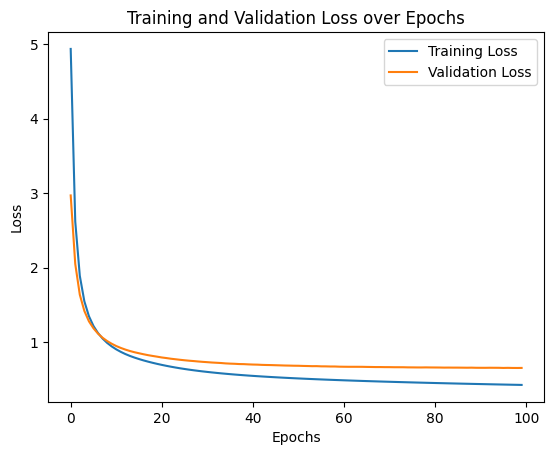

In [32]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import roc_curve

def calculate_eer(labels, distances):
    # Compute the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(labels, -distances)  # Negate distances to treat them as similarity scores
    
    # Calculate false negative rate (FNR)
    fnr = 1 - tpr
    
    # Find the point where FPR and FNR are closest
    eer_index = np.nanargmin(np.abs(fpr - fnr))
    eer = (fpr[eer_index] + fnr[eer_index]) / 2
    eer_threshold = -thresholds[eer_index]
    
    return eer, eer_threshold

In [38]:
encoded_anchor = embedding_model.predict(np.array(test_x[0]))
encoded_positive = embedding_model.predict(np.array(test_x[1]))

distances = np.linalg.norm(encoded_anchor - encoded_positive, axis=1)

# Calculate EER and threshold
eer, thr = calculate_eer(test_y, distances)
print(f'EER: {eer*100:.2f}% at threshold: {thr:.4f}')

# Classification using the threshold from EER
test_num=len(test_y)
total_pos = np.sum(test_y)
total_neg = test_num - total_pos

true_pos = 0
false_pos = 0
true_neg = 0
false_neg = 0

for i in range(test_num):
    if distances[i] < thr:  # Predicted positive
        if test_y[i] == 1:  # Actually positive
            true_pos += 1
        else:  # Actually negative
            false_pos += 1
    else:  # Predicted negative
        if test_y[i] == 0:  # Actually negative
            true_neg += 1
        else:  # Actually positive
            false_neg += 1

# Calculate rates
# Calculate metrics
true_pos_rate = true_pos / total_pos  # True Positive Rate (Sensitivity/Recall)
false_pos_rate = false_pos / total_neg  # False Positive Rate
true_neg_rate = true_neg / total_neg  # True Negative Rate (Specificity)
false_neg_rate = false_neg / total_pos  # False Negative Rate

accuracy = (true_pos + true_neg) / test_num  # Accuracy

# Print the metrics
print("True Positive Rate (TPR/Recall): {:.10f}".format(true_pos_rate))
print("False Positive Rate (FPR): {:.10f}".format(false_pos_rate))
print("True Negative Rate (TNR/Specificity): {:.10f}".format(true_neg_rate))
print("False Negative Rate (FNR): {:.10f}".format(false_neg_rate))
print("Accuracy: {:.10f}".format(accuracy))

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
EER: 21.57% at threshold: 2.8598
True Positive Rate (TPR/Recall): 0.7843000000
False Positive Rate (FPR): 0.2156750000
True Negative Rate (TNR/Specificity): 0.7843250000
False Negative Rate (FNR): 0.2157000000
Accuracy: 0.7843125000
